# SD212: Graph mining
## Lab 7: Graph embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral, BiSpectral
from sknetwork.linalg import HalkoEig
from sknetwork.ranking import top_k
from sknetwork.utils import KMeansDense
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paristech.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [5]:
graph = karate_club(True)

In [6]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

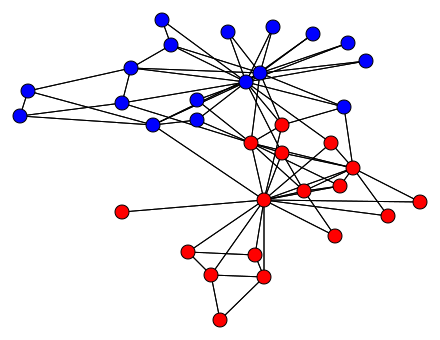

In [7]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with the embedding in dimension 2.
* Check that the embedding weighted by the degrees is centered and that the components have the same variance.
* How many nodes are misclassified using the sign of the first eigenvector? What are these nodes?

In [8]:
spectral = Spectral(20, normalized=False, regularization=None, scaling=0)

In [9]:
spectral.fit(adjacency)

Spectral(n_components=20, regularization=None, relative_regularization=True, scaling=0, normalized=False, solver='auto')

In [10]:
eigenvalues = spectral.eigenvalues_

In [11]:
eigenvalues

array([ 8.67727671e-01,  7.12951015e-01,  6.12686767e-01,  3.87769460e-01,
        3.51007053e-01,  2.92791798e-01,  2.60042011e-01,  2.29089383e-01,
        1.77057148e-01,  1.35167055e-01,  9.31839984e-02,  1.71492823e-16,
        5.43991071e-18,  7.67161342e-19,  7.75116692e-33,  3.11546330e-33,
       -3.91656381e-34, -2.93647143e-33, -6.33859457e-33, -2.64814757e-18])

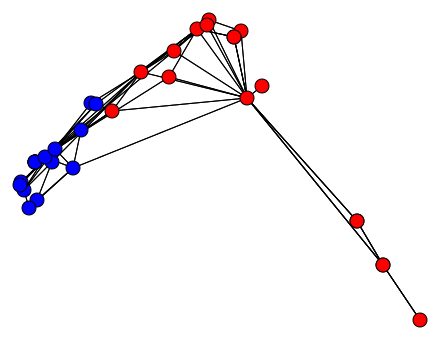

In [12]:
embedding = spectral.embedding_
image = svg_graph(adjacency, embedding, labels=labels_true)
SVG(image)

In [13]:
embedding.shape

(34, 20)

(34, 2)


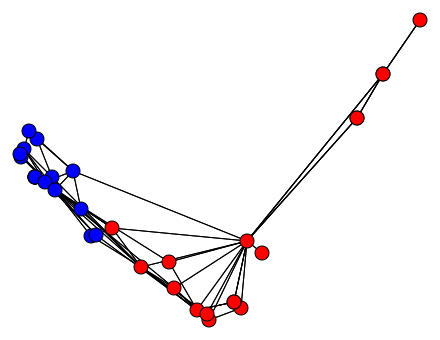

In [14]:
spectral = Spectral(2, normalized=False, regularization=None, scaling=0)
embedding = spectral.fit_transform(adjacency)
print(embedding.shape)
image = svg_graph(adjacency, embedding, labels=labels_true)
SVG(image)

In [15]:
vect = spectral.eigenvectors_
labels = []
for v in vect:
    if v[0] < 0 : 
        labels.append(0)
    else : 
        labels.append(1)
        
print(np.arange(len(labels))[labels != labels_true])

[2 8]


## Openflights


We now consider a larger graph. We use the Laplacian eigenmap in dimension 20. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we work on the embedding in the unit sphere, which can be obtained through the parameter ``normalized`` of the class ``Spectral``.

In [69]:
graph = openflights

In [70]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

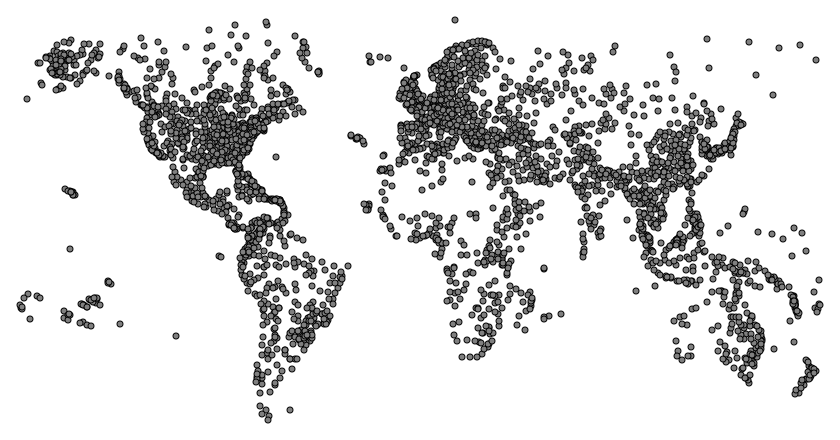

In [71]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian.
* Display the same world map with the scores equal to the cosine similarity to **Beijing** in the embedding space.
* List the 10 closest airports to **Madrid** in terms of cosine similarity in the embedding space.
* Display the same world map with 8 clusters found by k-means in the embedding space (still using cosing similarity).

In [91]:
spectral = Spectral(3, normalized=True, regularization=None, scaling=0)
spectral.fit(adjacency)

Spectral(n_components=3, regularization=None, relative_regularization=True, scaling=0, normalized=True, solver='auto')

In [92]:
eigenvalues = spectral.eigenvalues_

In [93]:
eigenvalues

array([0.94842208, 0.91404421, 0.90170683])

In [94]:
beijing = 1618

In [95]:
madrid = 572

In [96]:
embedding = spectral.embedding_
beijing_vector = embedding[beijing]

In [97]:
def cosine_similarity_(v1, v2):
    return v1.dot(v2) / np.sqrt(v1.dot(v1) * v2.dot(v2))

In [98]:
labels = []
for v in embedding : 
    labels.append(cosine_similarity_(v, beijing_vector))

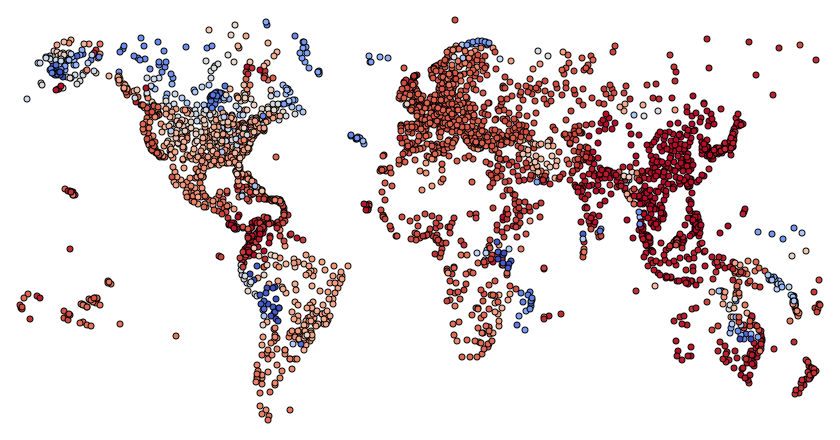

In [99]:
image = svg_graph(adjacency, position, scores = labels, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

In [100]:
madrid_scores = [cosine_similarity_(vectors, embedding[madrid]) for vectors in embedding]

In [101]:
names[top_k(np.array(madrid_scores),10)]

array(['Adolfo Suárez Madrid–Barajas Airport', 'Sialkot Airport',
       'Arar Domestic Airport', 'Gurayat Domestic Airport',
       'Sharurah Airport', 'Al-Jawf Domestic Airport',
       'Al Qaisumah/Hafr Al Batin Airport', 'Dawadmi Domestic Airport',
       'Pamplona Airport', 'Logroño-Agoncillo Airport'], dtype='<U65')

In [102]:
kmeans = KMeansDense()
kmeans.fit(embedding)
lab = kmeans.labels_

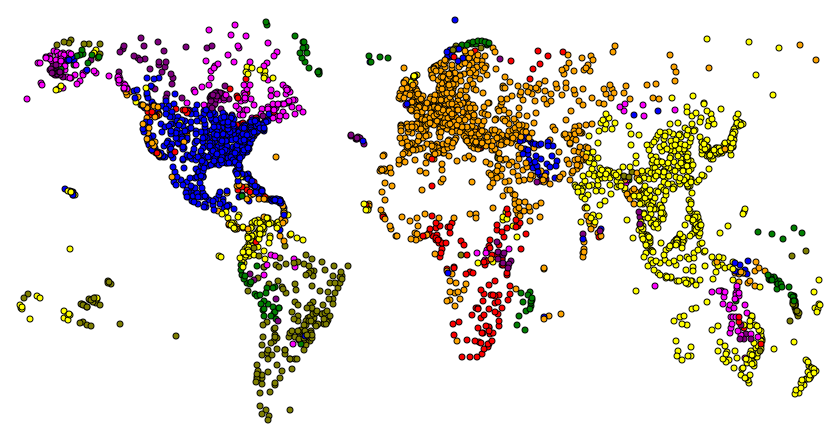

In [103]:
image = svg_graph(adjacency, position, labels = lab, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

In [104]:
tokyo = 1084
print(names[tokyo])

Tokyo Haneda International Airport


In [105]:
tokyo_scores = [cosine_similarity_(vectors, embedding[tokyo]) for vectors in embedding]
names[top_k(np.array(tokyo_scores),2)]

array(['Tokyo Haneda International Airport', 'Kushiro Airport'],
      dtype='<U65')

In [114]:
spectral = Spectral(20, normalized=True, regularization=None, scaling=0)
X = spectral.fit_transform(adjacency)
scores = X.dot(X[1084])
names[top_k(scores, 10)]

array(['Tokyo Haneda International Airport', 'Saga Airport',
       'Komatsu Airport', 'Takamatsu Airport', 'Oita Airport',
       'Kushiro Airport', 'Miho Yonago Airport', 'Matsuyama Airport',
       'Odate Noshiro Airport', 'Tokachi-Obihiro Airport'], dtype='<U65')

## 2. Directed graphs

## Wikipedia Vitals

We now consider a large directed graph. We use the class ``BiSpectral`` (i.e., the directed graph is viewed as a bipartite graph).

In [54]:
graph = wikivitals

In [55]:
adjacency = graph.adjacency
names = graph.names
labels = graph.labels_hierarchy
names_labels = graph.names_labels_hierarchy

## To do

* Check that the average cosine similarity between all node pairs in some set $S$ is given by the square norm of the barycenter of $S$.
* Give the average cosine similarity between nodes in the **Mammals** category.
* Compare with the expected cosine similarity between two nodes sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is high, give the most topical category and the less topical category among all categories having at least 10 articles. 

In [56]:
spectral = BiSpectral(20, solver=HalkoEig(random_state=42), regularization=None, scaling=0)
embedding = spectral.fit_transform(adjacency)

In [57]:
mammal = 274

In [58]:
names_labels[mammal]

'Biology and health sciences.Organisms.Animals.Mammals'

In [60]:
m = 0
ind = np.where(labels == mammal)[0]
for i in ind :
    for j in ind : 
        m+= cosine_similarity_(embedding[i],embedding[j])
print(m/len(ind)**2)

0.8207397494343444


In [61]:
n = 0 
for i in range(100): 
    ind1 = np.random.randint(len(labels))
    ind2 = np.random.randint(len(labels))
    n+= cosine_similarity_(embedding[ind1], embedding[ind2])
print(n/100)

-0.035432597462518534


In [62]:
lab, counts = np.unique(labels, return_counts = True)

In [63]:
lab = lab[counts > 10]

In [64]:
cosine_mean = []
for l in lab : 
    m = 0
    ind = np.where(labels == l)[0]
    for i in ind :
        for j in ind : 
            m+= cosine_similarity_(embedding[i],embedding[j])
    cosine_mean.append(m/len(ind)**2)

In [65]:
names_labels[lab[np.argsort(cosine_mean)[-10:]]]

array(['People.Sports figures.Individual sports.Athletics',
       'Geography.Physical geography.Bodies of water.Oceans and seas.Atlantic Ocean',
       'Physical sciences.Chemistry.Chemical substances.Chemical elements',
       'Everyday life.Sports and recreation.Sports.Team sports',
       'Mathematics.Algebra.Abstract algebra',
       'Geography.Countries.Africa.Central Africa',
       'Philosophy and religion.Mythology.Greco-Roman mythology.Greek deities',
       'Geography.Countries.Africa.West Africa',
       'Geography.Physical geography.Bodies of water.Oceans and seas.Pacific Ocean',
       'Physical sciences.Measurement.Units of measurement.Electromagnetism'],
      dtype='<U136')

In [66]:
top_cat = lab[np.argsort(cosine_mean)[-1]]
cosine_article = []
ind = np.where(labels == top_cat)[0]
for i in ind :
    m = 0
    for j in ind : 
        m+= cosine_similarity_(embedding[i],embedding[j])
    cosine_article.append(m/len(ind))

In [68]:
names[ind[np.argsort(cosine_article)[-1]]]

'Henry (unit)'

## 3. Bipartite graphs

Finally, we consider the co-embedding of each part of a bipartite graph. We focus on the bipartite graph formed by words used in the summaries of the articles of Wikivitals. 

## Wikipedia Vitals

In [68]:
graph = wikivitals

In [69]:
biadjacency = graph.biadjacency
articles = graph.names_row
words = graph.names_col

In [70]:
biadjacency

<10012x31323 sparse matrix of type '<class 'numpy.int64'>'
	with 995919 stored elements in Compressed Sparse Row format>

## To do

* What are now the most topical category and the less topical category among all categories having at least 10 articles?
* List the 10 most topical words associated with the most topical category, among all words used at least 10 times in the whole dataset.